In [19]:
# Imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import time
from datetime import datetime
import os
import plotly.io as pio
from colorama import init, Fore, Style
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                           mean_absolute_error, mean_absolute_percentage_error)

# Initialisation
init()  # Initialisation de colorama
pio.renderers.default = "browser"

# Configuration pandas et matplotlib
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8')

# Créer le dossier data s'il n'existe pas
if not os.path.exists('data'):
    os.makedirs('data')

# Boucle principale pour 2 scrapings
for iteration in range(1, 3):
    try:
        print("\n" + "="*50)
        print(Fore.CYAN + f"\n🔄 SCRAPING {iteration}/2 - {datetime.now().strftime('%H:%M:%S')}" + Style.RESET_ALL)
        print("="*50)

        start_time = time.time()

        # Création de la base de données SQLite
        try:
            conn = sqlite3.connect('data/jobs_database.db')
            cursor = conn.cursor()

            cursor.execute('''
            CREATE TABLE IF NOT EXISTS jobs (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                titre TEXT,
                salaire TEXT,
                localisation TEXT,
                type_contrat TEXT,
                competences TEXT,
                experience TEXT,
                date_scraping TIMESTAMP
            )
            ''')
            conn.commit()
            print(Fore.GREEN + "Base de données créée avec succès!" + Style.RESET_ALL)
        except Exception as e:
            print(Fore.RED + f"Erreur lors de la création de la base de données: {e}" + Style.RESET_ALL)
            continue

        # Liste pour stocker les données
        jobs_data = []

        try:
            # Initialisation du WebDriver
            driver = webdriver.Chrome()
            driver.maximize_window()

            url = "https://welovedevs.com/app/jobs"
            driver.get(url)
            time.sleep(3)

            # Remplir le champ "Poste"
            search_box_poste = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, '//input[@placeholder="Job search"]'))
            )
            search_box_poste.send_keys("data")

            # Défilement infini
            SCROLL_PAUSE_TIME = 3
            MAX_SCROLL_ATTEMPTS = 50
            last_height = driver.execute_script("return document.body.scrollHeight")
            offers_loaded = set()

            for attempt in range(MAX_SCROLL_ATTEMPTS):
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(SCROLL_PAUSE_TIME)

                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    print(Fore.YELLOW + "Fin du défilement, aucune nouvelle donnée chargée." + Style.RESET_ALL)
                    break
                last_height = new_height

                soup = BeautifulSoup(driver.page_source, "html.parser")
                current_offers = soup.find_all("div", class_="sc-flex sc-flex-col sc-min-w-0 sc-flex-1 sc-w-full")

                for offer in current_offers:
                    offers_loaded.add(str(offer))

            print(Fore.CYAN + f"Total des offres récupérées : {len(offers_loaded)}" + Style.RESET_ALL)

            # Traitement des offres
            insertions_reussies = 0
            for offer_html in offers_loaded:
                offer = BeautifulSoup(offer_html, "html.parser")
                try:
                    title = offer.find("span", class_="group-hover:sc-underline")
                    salary = offer.find("div", class_="ds-font-w3d ds-text-dark-500 ds-text-base sc-flex sc-items-center sc-mb-1 sc-min-w-0 sc-whitespace-nowrap sc-text-sm")
                    location = offer.find("span", class_="truncate")
                    contract_type = offer.find("span", string=lambda text: text and "contract" in text.lower())
                    skills = offer.find_all("span", class_="sc-text-sm")
                    experience = offer.find("div", class_="ds-font-w3d ds-text-dark-500 ds-text-base sc-flex sc-whitespace-nowrap sc-mr-2 sc-mb-1 sc-items-center sc-min-w-fit sc-text-sm")
                    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                    job_data = {
                        "Titre": title.text.strip() if title else "Non précisé",
                        "Salaire": salary.text.strip() if salary else "Non précisé",
                        "Localisation": location.text.strip() if location else "Non précisé",
                        "Type_contrat": contract_type.text.strip() if contract_type else "Non précisé",
                        "Competences": ", ".join(skill.text.strip() for skill in skills) if skills else "Non précisé",
                        "Experience": experience.text.strip() if experience else "Non précisé",
                        "Date_scraping": current_time
                    }

                    # Insertion dans SQLite
                    cursor.execute('''
                        INSERT INTO jobs (titre, salaire, localisation, type_contrat, competences, experience, date_scraping)
                        VALUES (?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        job_data["Titre"],
                        job_data["Salaire"],
                        job_data["Localisation"],
                        job_data["Type_contrat"],
                        job_data["Competences"],
                        job_data["Experience"],
                        job_data["Date_scraping"]
                    ))
                    conn.commit()
                    insertions_reussies += 1
                    jobs_data.append(job_data)

                except Exception as e:
                    print(Fore.RED + f"Erreur lors du traitement d'une offre: {e}" + Style.RESET_ALL)
                    continue

            print(Fore.GREEN + f"Nombre d'insertions réussies dans SQLite: {insertions_reussies}" + Style.RESET_ALL)

        except Exception as e:
            print(Fore.RED + f"Erreur lors du scraping: {e}" + Style.RESET_ALL)
        finally:
            driver.quit()

        # Sauvegarde et nettoyage des données
        if jobs_data:
            try:
                # Créer un DataFrame
                df = pd.DataFrame(jobs_data)

                # Générer un nom de fichier avec la date et l'heure
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"data/jobs_data_{timestamp}.csv"

                # Sauvegarder en CSV
                df.to_csv(filename, index=False, encoding='utf-8-sig')
                print(Fore.GREEN + f"\nDonnées sauvegardées dans {filename}" + Style.RESET_ALL)

                def nettoyer_donnees(df):
                    df_clean = df.copy()

                    # Nettoyage des titres
                    df_clean['Titre'] = df_clean['Titre'].str.strip().str.lower()

                    # Nettoyage des localisations
                    df_clean['Localisation'] = df_clean['Localisation'].str.strip()
                    df_clean[['Ville', 'Pays']] = df_clean['Localisation'].str.extract(r'([^,]+),\s*(.+)')
                    df_clean['Ville'] = df_clean['Ville'].str.strip()
                    df_clean['Pays'] = df_clean['Pays'].str.strip()

                    # Standardisation des types de contrat
                    df_clean['Type_contrat'] = df_clean['Type_contrat'].str.strip().str.lower()
                    df_clean['Type_contrat'] = df_clean['Type_contrat'].replace({
                        'permanent contract': 'CDI',
                        'fixed-term contract': 'CDD',
                        'freelance contract': 'Freelance',
                        'internship contract': 'Stage'
                    })

                    # Nettoyage des compétences
                    df_clean['Competences'] = df_clean['Competences'].str.strip().str.lower()
                    df_clean['Competences_list'] = df_clean['Competences'].str.split(',')
                    df_clean['Competences_list'] = df_clean['Competences_list'].apply(
                        lambda x: [skill.strip() for skill in x] if isinstance(x, list) else []
                    )

                    # Nettoyage des salaires
                    def nettoyer_salaire(salaire):
                        if pd.isna(salaire) or salaire == 'Non précisé':
                            return None
                        import re
                        nombres = re.findall(r'\d+(?:,\d+)?', str(salaire))
                        if nombres:
                            nombres = [float(n.replace(',', '')) for n in nombres]
                            return sum(nombres) / len(nombres)
                        return None

                    df_clean['Salaire_moyen'] = df_clean['Salaire'].apply(nettoyer_salaire)

                    # Autres nettoyages
                    df_clean['Date_scraping'] = pd.to_datetime(df_clean['Date_scraping'])
                    df_clean['Nombre_competences'] = df_clean['Competences_list'].str.len()
                    df_clean['Mois_scraping'] = df_clean['Date_scraping'].dt.strftime('%Y-%m')

                    # Suppression des doublons
                    df_clean = df_clean.drop_duplicates(subset=['Titre', 'Localisation', 'Type_contrat'])

                    return df_clean

                # Nettoyage des données
                df = nettoyer_donnees(df)

                # Sauvegarde des données nettoyées
                filename_clean = f"data/jobs_data_clean_{timestamp}.csv"
                df.to_csv(filename_clean, index=False, encoding='utf-8-sig')
                print(Fore.GREEN + f"\nDonnées nettoyées sauvegardées dans {filename_clean}" + Style.RESET_ALL)

            except Exception as e:
                print(Fore.RED + f"Erreur lors de la sauvegarde et du nettoyage: {e}" + Style.RESET_ALL)

        end_time = time.time()
        execution_time = end_time - start_time

        print("\n" + "="*50)
        print(Fore.GREEN + f"✅ Fin du scraping {iteration}/2" + Style.RESET_ALL)
        print(Fore.YELLOW + f"⏱️ Temps d'exécution : {execution_time:.2f} secondes" + Style.RESET_ALL)

        if iteration < 2:
            print(Fore.CYAN + "⏳ Attente de 1 minutes avant le prochain scraping..." + Style.RESET_ALL)
            print("="*50 + "\n")
            time.sleep(60)
        else:
            print(Fore.GREEN + "✨ Scrapings terminés, continuation du programme..." + Style.RESET_ALL)
            print("="*50 + "\n")

    except KeyboardInterrupt:
        print("\n" + "="*50)
        print(Fore.RED + "🛑 Arrêt manuel du programme" + Style.RESET_ALL)
        print("="*50)
        break
    except Exception as e:
        print("\n" + "="*50)
        print(Fore.RED + f"❌ Erreur lors du scraping {iteration}: {e}" + Style.RESET_ALL)
        if iteration < 2:
            print(Fore.YELLOW + "⏳ Attente de 1 minutes avant nouvelle tentative..." + Style.RESET_ALL)
            print("="*50 + "\n")
            time.sleep(60)
        else:
            print(Fore.RED + "❌ Arrêt des scrapings" + Style.RESET_ALL)
            print("="*50 + "\n")
# Analyse rapide des données
try:
    print(Fore.CYAN + "\n=== 📊 ANALYSE DES DONNÉES ===" + Style.RESET_ALL)

    # Analyse des compétences
    all_skills = [skill.strip() for skills in df['Titre'].str.split(',') for skill in skills if skill.strip() != "Non précisé"]
    skills_series = pd.Series(all_skills)

    print(Fore.YELLOW + "\nTop 10 des métiers recherchés :" + Style.RESET_ALL)
    print(skills_series.value_counts().head(10))

    # Statistiques sur les salaires
    print(Fore.YELLOW + "\nRépartition des salaires :" + Style.RESET_ALL)
    print(df['Salaire'].value_counts().head())

except Exception as e:
    print(Fore.RED + f"Erreur lors de l'analyse des données: {e}" + Style.RESET_ALL)

print("\n" + "="*50)
print(Fore.GREEN + "✨ Programme terminé" + Style.RESET_ALL)
print("="*50)


# Fermeture de la connexion SQLite
if 'conn' in locals():
    conn.close()
    print(Fore.GREEN + "\nConnexion à la base de données fermée." + Style.RESET_ALL)




🔄 SCRAPING 1/2 - 09:20:46
Base de données créée avec succès!
Fin du défilement, aucune nouvelle donnée chargée.
Total des offres récupérées : 409
Nombre d'insertions réussies dans SQLite: 409

Données sauvegardées dans data/jobs_data_20241118_092332.csv

Données nettoyées sauvegardées dans data/jobs_data_clean_20241118_092332.csv

✅ Fin du scraping 1/2
⏱️ Temps d'exécution : 166.88 secondes
⏳ Attente de 1 minutes avant le prochain scraping...



🔄 SCRAPING 2/2 - 09:24:33
Base de données créée avec succès!
Fin du défilement, aucune nouvelle donnée chargée.
Total des offres récupérées : 411
Nombre d'insertions réussies dans SQLite: 411

Données sauvegardées dans data/jobs_data_20241118_092740.csv

Données nettoyées sauvegardées dans data/jobs_data_clean_20241118_092740.csv

✅ Fin du scraping 2/2
⏱️ Temps d'exécution : 188.01 secondes
✨ Scrapings terminés, continuation du programme...


=== 📊 ANALYSE DES DONNÉES ===

Top 10 des métiers recherchés :
technicien systèmes numériques - dével


=== 📊 ANALYSE DÉTAILLÉE DES OFFRES D'EMPLOI ===

📌 Nombre total d'offres : 400


Nombre d'offres,400
Nombre de pays,19
Moyenne de compétences requises,5.8
Salaire moyen,52.81€
Nombre de villes différentes,170



=== 📊 VISUALISATIONS ===


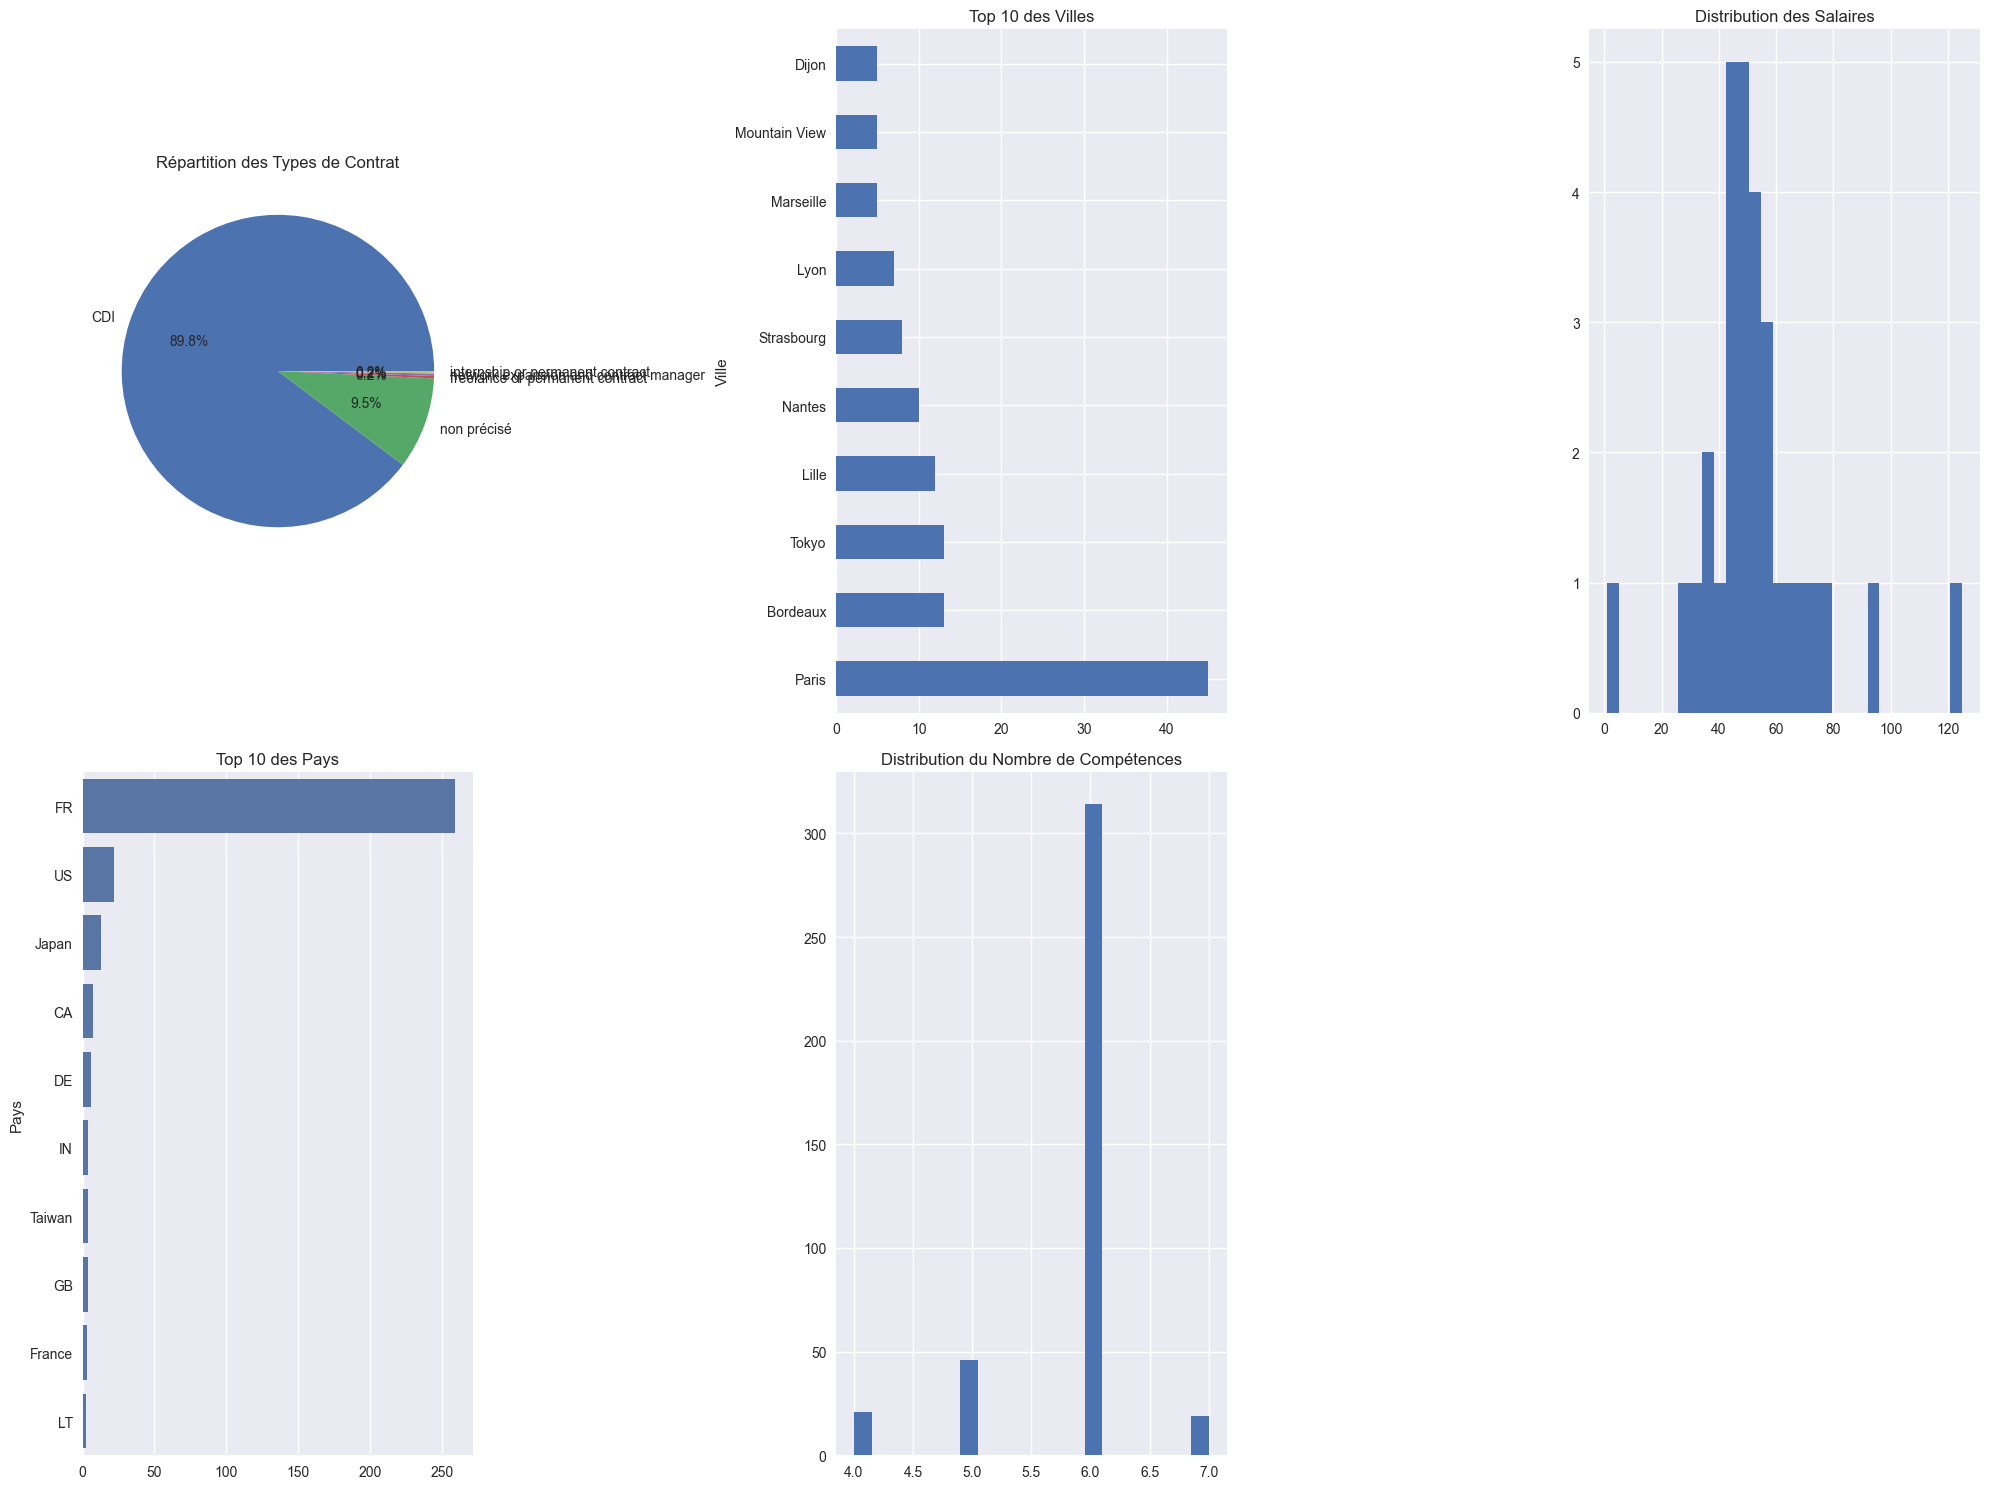


=== 📊 ANALYSE DES COMPÉTENCES ===

=== 📊 Statistiques Supplémentaires ===

Salaire moyen par type de contrat:
Type_contrat
CDI                                       56.527778
freelance or permanent contract           44.000000
internship or permanent contract          42.500000
network expansion and contract manager          NaN
non précisé                               35.250000
Name: Salaire_moyen, dtype: float64

Nombre moyen de compétences requises par pays:
Pays
ES    7.000000
IN    6.500000
LT    6.500000
US    6.318182
FR    6.030888
Name: Nombre_competences, dtype: float64

✨ Analyse terminée


In [20]:
# Analyse détaillée et visualisations
try:
    print(Fore.CYAN + "\n=== 📊 ANALYSE DÉTAILLÉE DES OFFRES D'EMPLOI ===" + Style.RESET_ALL)
    print(Fore.YELLOW + f"\n📌 Nombre total d'offres : {len(df)}" + Style.RESET_ALL)

    # Création du HTML pour les statistiques
    stats_html = """
    <div style="background-color: #f5f5f5; padding: 20px; border-radius: 10px;">
        <h3>📈 Statistiques Détaillées</h3>
        <table>
            <tr><td><b>Nombre d'offres</b></td><td>{}</td></tr>
            <tr><td><b>Nombre de pays</b></td><td>{}</td></tr>
            <tr><td><b>Moyenne de compétences requises</b></td><td>{:.1f}</td></tr>
            <tr><td><b>Salaire moyen</b></td><td>{:.2f}€</td></tr>
            <tr><td><b>Nombre de villes différentes</b></td><td>{}</td></tr>
        </table>
    </div>
    """.format(
        len(df),
        df['Pays'].nunique(),
        df['Nombre_competences'].mean(),
        df['Salaire_moyen'].mean(),
        df['Ville'].nunique()
    )

    display(HTML(stats_html))

    # Création des visualisations
    print(Fore.CYAN + "\n=== 📊 VISUALISATIONS ===" + Style.RESET_ALL)

    plt.figure(figsize=(20, 15))

    # 1. Types de contrat
    plt.subplot(2, 3, 1)
    contract_counts = df['Type_contrat'].value_counts()
    plt.pie(contract_counts.values, labels=contract_counts.index, autopct='%1.1f%%')
    plt.title('Répartition des Types de Contrat')

    # 2. Top 10 des villes
    plt.subplot(2, 3, 2)
    city_counts = df['Ville'].value_counts().head(10)
    city_counts.plot(kind='barh')
    plt.title('Top 10 des Villes')

    # 3. Distribution des salaires
    plt.subplot(2, 3, 3)
    df['Salaire_moyen'].hist(bins=30)
    plt.title('Distribution des Salaires')

    # 4. Top pays
    plt.subplot(2, 3, 4)
    country_counts = df['Pays'].value_counts().head(10)
    sns.barplot(x=country_counts.values, y=country_counts.index)
    plt.title('Top 10 des Pays')

    # 5. Distribution du nombre de compétences
    plt.subplot(2, 3, 5)
    plt.hist(df['Nombre_competences'], bins=20)
    plt.title('Distribution du Nombre de Compétences')

    plt.tight_layout()
    plt.show()

    # Analyse des compétences avec visualisation interactive
    print(Fore.CYAN + "\n=== 📊 ANALYSE DES COMPÉTENCES ===" + Style.RESET_ALL)

    competences_exploded = df.explode('Competences_list')
    skills_counts = competences_exploded['Competences_list'].value_counts().head(15)

    # Graphique interactif des compétences
    fig = px.bar(x=skills_counts.index, y=skills_counts.values,
                 title='Top 15 des Compétences les Plus Demandées',
                 labels={'x': 'Compétence', 'y': 'Nombre d\'offres'},
                 template='plotly_white')

    fig.update_layout(
        showlegend=False,
        title_x=0.5,
        title_font_size=20,
        xaxis_tickangle=-45,
        height=600
    )

    # Graphique des salaires par type de contrat
    fig_salary = px.box(df,
                       x='Type_contrat',
                       y='Salaire_moyen',
                       title='Distribution des Salaires par Type de Contrat',
                       template='plotly_white')

    fig_salary.update_layout(
        title_x=0.5,
        title_font_size=20,
        height=500
    )

    # Affichage des graphiques
    fig.show()
    fig_salary.show()

    # Statistiques supplémentaires
    print(Fore.CYAN + "\n=== 📊 Statistiques Supplémentaires ===" + Style.RESET_ALL)

    # print(Fore.YELLOW + "\nTop 5 des combinaisons de compétences les plus demandées:" + Style.RESET_ALL)
    # print(df['Competences'].value_counts().head())

    print(Fore.YELLOW + "\nSalaire moyen par type de contrat:" + Style.RESET_ALL)
    print(df.groupby('Type_contrat')['Salaire_moyen'].mean())

    print(Fore.YELLOW + "\nNombre moyen de compétences requises par pays:" + Style.RESET_ALL)
    print(df.groupby('Pays')['Nombre_competences'].mean().sort_values(ascending=False).head())

except Exception as e:
    print(Fore.RED + f"\nErreur lors de l'analyse et des visualisations: {e}" + Style.RESET_ALL)

print("\n" + "="*50)
print(Fore.GREEN + "✨ Analyse terminée" + Style.RESET_ALL)
print("="*50)


=== 🤖 MODÉLISATION ET PRÉDICTION DES SALAIRES ===

Début du pipeline d'analyse...

Analyse des données initiales:
Nombre total d'offres: 400
Salaires manquants: 370
Salaire moyen: 52.81€
Salaire médian: 48.25€


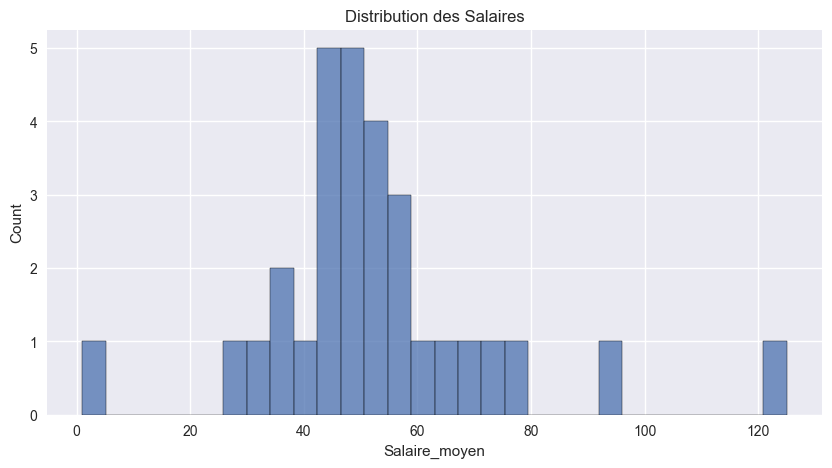


Statistiques après nettoyage:
Nombre d'échantillons: 23
Salaire moyen: 50.04€
Salaire médian: 48.00€

Features sélectionnées:
- Type_contrat_encoded
- Pays_encoded
- Competences_norm
- Contrat_Competences
- skill_permanent contract
- skill_fr
- skill_sfeir
- skill_harry hope
- skill_lille

=== 📊 RÉSULTATS DU MODÈLE ===
MSE (Train): 70.65€
MSE (Test): 18.94€
R2 (Train) (%): 7.32%
R2 (Test) (%): 0.00%
Accuracy (Train) (%): 44.44%
Accuracy (Test) (%): 60.00%


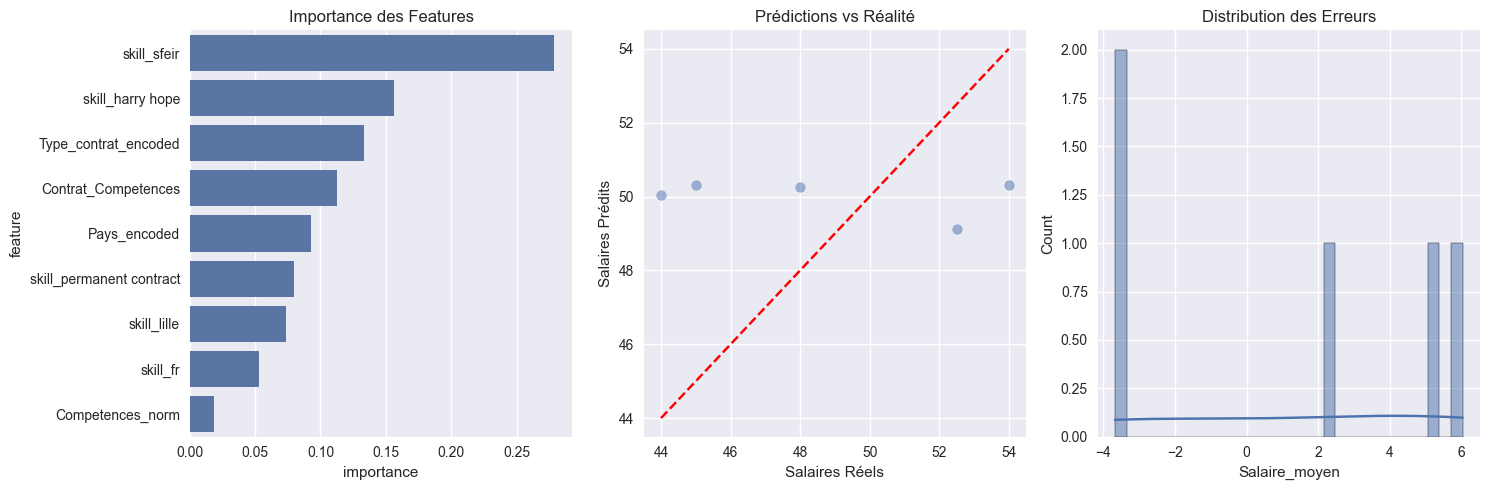


Modèle sauvegardé avec succès!

=== 💰 EXEMPLE DE PRÉDICTION ===
Salaire prédit pour l'exemple: 50.61€


In [21]:
# Import des bibliothèques essentielles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import joblib
from colorama import Fore, Style

print(Fore.CYAN + "=== 🤖 MODÉLISATION ET PRÉDICTION DES SALAIRES ===" + Style.RESET_ALL)

def analyser_donnees(df):
    """
    Analyse initiale des données
    """
    print(Fore.YELLOW + "\nAnalyse des données initiales:" + Style.RESET_ALL)
    print(f"Nombre total d'offres: {len(df)}")
    print(f"Salaires manquants: {df['Salaire_moyen'].isna().sum()}")
    print(f"Salaire moyen: {df['Salaire_moyen'].mean():.2f}€")
    print(f"Salaire médian: {df['Salaire_moyen'].median():.2f}€")

    # Affichage de la distribution des salaires
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x='Salaire_moyen', bins=30)
    plt.title('Distribution des Salaires')
    plt.show()

    return df

def nettoyer_donnees(df):
    """
    Nettoyage des données avec gestion des NaN
    """
    df_clean = df.copy()

    # 1. Suppression des lignes avec NaN dans les colonnes essentielles
    colonnes_essentielles = ['Salaire_moyen', 'Type_contrat', 'Pays', 'Competences_list']
    df_clean = df_clean.dropna(subset=colonnes_essentielles)

    # 2. Nettoyage des salaires par type de contrat
    for contrat in df_clean['Type_contrat'].unique():
        mask = df_clean['Type_contrat'] == contrat
        q1 = df_clean.loc[mask, 'Salaire_moyen'].quantile(0.05)
        q3 = df_clean.loc[mask, 'Salaire_moyen'].quantile(0.95)
        df_clean = df_clean.loc[~(mask & ((df_clean['Salaire_moyen'] < q1) | (df_clean['Salaire_moyen'] > q3)))]

    print(f"\nStatistiques après nettoyage:")
    print(f"Nombre d'échantillons: {len(df_clean)}")
    print(f"Salaire moyen: {df_clean['Salaire_moyen'].mean():.2f}€")
    print(f"Salaire médian: {df_clean['Salaire_moyen'].median():.2f}€")

    return df_clean

def preparer_features(df_clean):
    """
    Préparation des features avec gestion des NaN
    """
    # 1. Encodage des variables catégorielles
    le = LabelEncoder()
    df_clean['Type_contrat_encoded'] = le.fit_transform(df_clean['Type_contrat'])
    df_clean['Pays_encoded'] = le.fit_transform(df_clean['Pays'])

    # 2. Features de base avec normalisation
    df_clean['Competences_norm'] = df_clean['Nombre_competences'] / df_clean['Nombre_competences'].max()

    # 3. Features d'interaction
    df_clean['Contrat_Competences'] = df_clean['Type_contrat_encoded'] * df_clean['Competences_norm']

    # 4. Traitement des compétences
    competences_dummies = pd.get_dummies(
        df_clean['Competences_list'].explode()
    ).groupby(level=0).sum()

    # 5. Features principales
    features = [
        'Type_contrat_encoded',
        'Pays_encoded',
        'Competences_norm',
        'Contrat_Competences'
    ]

    # 6. Ajout des compétences principales
    top_skills = competences_dummies.sum().nlargest(5).index
    for skill in top_skills:
        feature_name = f'skill_{skill}'
        df_clean[feature_name] = competences_dummies[skill]
        features.append(feature_name)

    # 7. Vérification finale des NaN
    X = df_clean[features]
    if X.isnull().any().any():
        print("\nAttention: NaN détectés dans les features!")
        X = X.fillna(0)

    print(Fore.YELLOW + "\nFeatures sélectionnées:" + Style.RESET_ALL)
    for f in features:
        print(f"- {f}")

    return df_clean, features

def entrainer_modele(df_clean, features):
    """
    Entraînement avec gestion des NaN
    """
    X = df_clean[features].fillna(0)
    y = df_clean['Salaire_moyen']

    # Split avec moins de strates
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=pd.qcut(y, q=3, duplicates='drop')
    )

    # Standardisation robuste
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Modèle optimisé
    model = RandomForestRegressor(
        n_estimators=150,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        bootstrap=True,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    return model, scaler, X_train_scaled, X_test_scaled, y_train, y_test

def evaluer_modele(model, X_train_scaled, X_test_scaled, y_train, y_test):
    """
    Évaluation complète du modèle
    """
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    metriques = {
        'MSE (Train)': mean_squared_error(y_train, y_pred_train),
        'MSE (Test)': mean_squared_error(y_test, y_pred_test),
        'R2 (Train) (%)': max(0, r2_score(y_train, y_pred_train) * 100),
        'R2 (Test) (%)': max(0, r2_score(y_test, y_pred_test) * 100),
        'Accuracy (Train) (%)': np.mean(np.abs(y_pred_train - y_train) <= 0.1 * y_train) * 100,
        'Accuracy (Test) (%)': np.mean(np.abs(y_pred_test - y_test) <= 0.1 * y_test) * 100
    }

    return metriques, y_pred_test

def visualiser_resultats(model, features, y_test, y_pred_test):
    """
    Visualisation des résultats
    """
    plt.figure(figsize=(15, 5))

    # 1. Importance des features
    plt.subplot(1, 3, 1)
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(x='importance', y='feature', data=importance)
    plt.title('Importance des Features')

    # 2. Prédictions vs Réalité
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Salaires Réels')
    plt.ylabel('Salaires Prédits')
    plt.title('Prédictions vs Réalité')

    # 3. Distribution des erreurs
    plt.subplot(1, 3, 3)
    erreurs = y_pred_test - y_test
    sns.histplot(erreurs, bins=30, kde=True)
    plt.title('Distribution des Erreurs')

    plt.tight_layout()
    plt.show()

# Pipeline principal
print(Fore.YELLOW + "\nDébut du pipeline d'analyse..." + Style.RESET_ALL)

# Exécution du pipeline
df = analyser_donnees(df)
df_clean = nettoyer_donnees(df)
df_clean, features = preparer_features(df_clean)
model, scaler, X_train_scaled, X_test_scaled, y_train, y_test = entrainer_modele(df_clean, features)
metriques, y_pred_test = evaluer_modele(model, X_train_scaled, X_test_scaled, y_train, y_test)

# Affichage des résultats
print(Fore.CYAN + "\n=== 📊 RÉSULTATS DU MODÈLE ===" + Style.RESET_ALL)
for metric, value in metriques.items():
    if 'MSE' in metric:
        print(Fore.YELLOW + f"{metric}: {value:.2f}€" + Style.RESET_ALL)
    else:
        print(Fore.GREEN + f"{metric}: {value:.2f}%" + Style.RESET_ALL)

# Visualisation des résultats
visualiser_resultats(model, features, y_test, y_pred_test)

# Sauvegarde du modèle
joblib.dump(model, 'data/salary_prediction_model.joblib')
joblib.dump(scaler, 'data/salary_prediction_scaler.joblib')
print(Fore.GREEN + "\nModèle sauvegardé avec succès!" + Style.RESET_ALL)

# Exemple de prédiction
print(Fore.CYAN + "\n=== 💰 EXEMPLE DE PRÉDICTION ===" + Style.RESET_ALL)
exemple = pd.DataFrame([{feature: 0 for feature in features}])
salaire_predit = model.predict(scaler.transform(exemple))[0]
print(f"Salaire prédit pour l'exemple: {salaire_predit:.2f}€")
